<a href="https://colab.research.google.com/github/bilzard/JQuants-news/blob/main/005_Predict_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

このnotebookでは、私が最終的に提出したモデルの学習に使ったソースコードについて説明します。

全体的な戦略としては、テクニカル指標のみをつかい、学習済みのLightGBMで予測した翌週のリターンが最も高い5銘柄をポートフォリオに組み入れました。

In [1]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ライブラリのバージョンを調整します
!pip install --no-cache-dir joblib==1.0.1 numpy==1.19.5 pandas==1.1.5 scikit-learn==0.20.3 scipy==1.2.1 seaborn==0.9.0 ta==0.7.0 lightgbm==2.2.3

     |████████████████████████████████| 5.4MB 5.7MB/s 
     |████████████████████████████████| 24.8MB 1.4MB/s 
     |████████████████████████████████| 215kB 46.5MB/s 
  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=80bc962d4591d5e9d81d9547a4194f6ec8c19449eaa11f80314fa821ebceac02
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4kyfyop/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [3]:
import io
import os
import sys
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
from IPython.core.magic import register_cell_magic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# インポート時にエラーが出た場合は、以下のmodule_dirをbacktest.pyを配置したディレクトリに変更してください。
import sys
if 'google.colab' in sys.modules:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = f"{mount_dir}/MyDrive/JPX_competition/Chapter03/backtest"
else:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = "/notebook/Chapter03/backtest" 
sys.path.append(module_dir)

from backtest import Backtest

In [6]:
# 表示用の設定を変更します
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [7]:
# データセットを配置したディレクトリのパスを設定
if 'google.colab' in sys.modules:
    dataset_dir = f"{mount_dir}/MyDrive/JPX_competition/data_dir_comp2"
else:
    dataset_dir = "/notebook/data_dir_comp2"

In [8]:
# 入力パラメーターを設定します。ランタイム環境での実行時と同一フォーマットにします
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price_past": f"{dataset_dir}/stock_price_past.csv.gz",
    "stock_price_latest": f"{dataset_dir}/stock_price_latest.csv.gz",
}

In [9]:
# 銘柄情報読み込み
df_stock_list = pd.read_csv(inputs["stock_list"])
# 問題2のユニバース (投資対象の条件を満たす銘柄群) 取得
codes = df_stock_list.loc[
    df_stock_list.loc[:, "universe_comp2"] == True, "Local Code"
].unique()

In [14]:
# 価格情報読み込み、インデックス作成
df_price = pd.concat([
                      pd.read_csv(inputs["stock_price_past"]),
                      pd.read_csv(inputs['stock_price_latest']),
], ignore_index=True).set_index("EndOfDayQuote Date")
# 日付型に変換
df_price.index = pd.to_datetime(df_price.index, format="%Y-%m-%d")

In [15]:
# 投資対象日付を指定します
start_dt = pd.Timestamp("2020-01-01")

In [16]:
if "purchase_date" in inputs.keys():
    # ランタイム環境では指定された投資対象日付を使用します
    # purchase_dateを読み込み
    df_purchase_date = pd.read_csv(inputs["purchase_date"])
    # purchase_dateの最も古い日付を投資対象日付として使用します
    start_dt = pd.Timestamp(df_purchase_date.sort_values("Purchase Date").iloc[0, 0])

In [17]:
# 投資対象日の前週金曜日時点で予測を出力するため、予測出力用の日付を設定します。
pred_start_dt = pd.Timestamp(start_dt) - pd.Timedelta("3D")
# 特徴量の生成に必要な日数をバッファとして設定
n = 30
# データ絞り込み日付設定
data_start_dt = pred_start_dt - pd.offsets.BDay(n)
# 日付で絞り込み
filter_date = df_price.index.get_level_values(0) >= data_start_dt
# 銘柄をユニバースで絞り込み
filter_universe = df_price['Local Code'].isin(codes)
# 絞り込み実施
df_price = df_price.loc[filter_date & filter_universe]

# 特徴量の作成

特徴量の生成にはテクニカル指標を簡単に生成できるライブラリ [ta](https://github.com/bukosabino/ta) を使います。

all_ta_features ですべての特徴量を生成します。

生成される特徴量の定義は以下を参照:
https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html

ほかにも [ta-lib](https://github.com/mrjbq7/ta-lib) というライブラリがありますが、コンパイルが必要で、ランタイム環境で動作する確証がなかったので使いませんでした。

In [18]:
from ta import add_all_ta_features
from ta.utils import dropna

In [19]:
def create_talib_feature(input_df):
  df_list = []

  for asset in tqdm(input_df['Local Code'].unique()):
    filter_asset = input_df['Local Code'] == asset
    df = add_all_ta_features(
      input_df[filter_asset].copy(), open='EndOfDayQuote Open', high='EndOfDayQuote High', low='EndOfDayQuote Low', close='EndOfDayQuote Close', volume='EndOfDayQuote Volume')
    df_list.append(df)

  out_df = pd.concat(df_list)
  out_df = out_df.reset_index().sort_values(['EndOfDayQuote Date', 'Local Code']).set_index('EndOfDayQuote Date')
  return out_df

In [20]:
def drop_too_much_na_asset(input_df, threshold=.95):
  df_ = input_df[['EndOfDayQuote Close', 'Local Code']]

  df_ = pd.pivot_table(df_, columns='Local Code', values='EndOfDayQuote Close', index='EndOfDayQuote Date')
  filter_notna_columns = df_.notna().mean() > threshold
  valid_columns = df_.columns[filter_notna_columns].values

  filter_valid_column = input_df['Local Code'].isin(valid_columns)
  return input_df[filter_valid_column]

In [21]:
dropped_df = drop_too_much_na_asset(df_price)

テクニカル指標の分析にはある程度の期間のデータが必要です。
また、後述するように、訓練データと評価データをさらに短い期間に区切る予定なので、欠測値が多い銘柄を除外します。
ここでは、欠測値を5%以上含むカラムを除外することにしました。

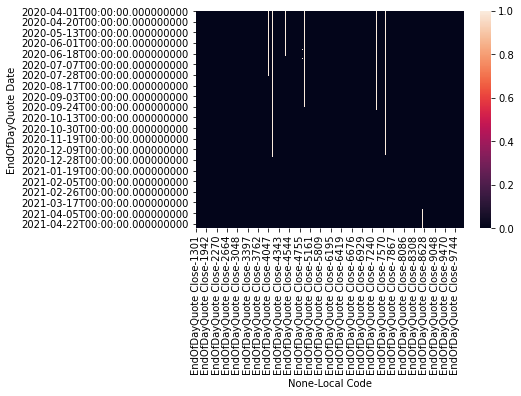

In [22]:
sns.heatmap(pd.pivot_table(df_price, columns=['Local Code'], values=['EndOfDayQuote Close'], index=df_price.index).isna())

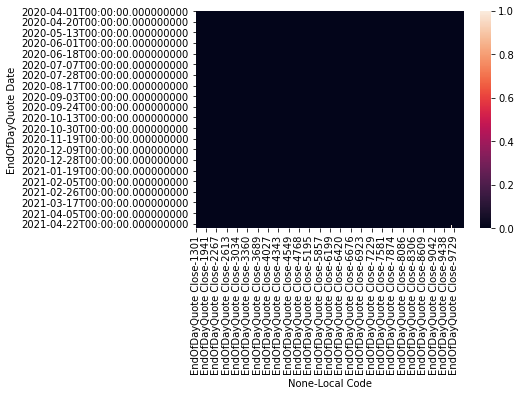

In [23]:
sns.heatmap(pd.pivot_table(dropped_df, columns=['Local Code'], values=['EndOfDayQuote Close'], index=dropped_df.index).isna())

以下の関数はややトリッキー（かつ汎用性がない）ですが、週を一意に特定するためのIDを生成する関数です。

のちに週次リターンを計算するさい、週の情報でグループ化しますが、weekの情報だけでグルーピングすると2020年のデータと2021のデータが重複するためです。

なお、2020年と2021年のデータにしか対応していません。他の年のデータを入力すると正しく計算できないので注意してください。

また、本質とはずれるため詳しい計算の中身の説明は省略します（詳細は[1]を参照）。

[1] https://en.wikipedia.org/wiki/ISO_week_date

In [42]:
def convert_week_id(index):
    def convert_date_of_thursday(index):
        return index + pd.Timedelta(f'{3 - index.dayofweek}D')

    # 同じ weekofyear に属する木曜日の日付を求める   
    index_thursday = pd.DatetimeIndex(map(convert_date_of_thursday , index))
    years = index_thursday.year

    assert len(index_thursday) == len(index), f'{len(index_thursday)} != {len(index)} must be same length'
    
    weeks = index.week
    return (years - 2020) * 53 + index.week

## 交差検証用の特徴量生成

交差検証のため、訓練データ(training set)と評価データ(validation set)を生成します。
何も考えずに分けると本来その時点では知り得ないデータが含まれてしまいます。
そこで、今回は本番と同じように「その時点で知り得るデータ」のみを与えて特徴量を生成する方針をとりました。

この方法のメリットは、「リークしないように訓練期間と評価データの間を十分開ける」といった対応をすることがないことです。
逆にデメリットは、交差検証のfold分データを生成するので、処理時間とメモリを多く消費することです。

今回は ta ライブラリがどの程度の期間を使って特徴量を生成するのか不明だったため、この方法をとりました。

## 交差検証データ

交差検証には、評価データの期間が訓練データの期間よりも後にくるように注意して、以下のようにfoldを切りました。
各foldの特徴量を計算するさいは、「そのfoldより前のデータ」のみを使う必要があることに注意してください。
したがって、同じ期間であっても、foldごとに異なる特徴量をもちます。
このため、学習中はすべてのfoldの特徴量を保持しておく必要があります。

<center><b>表1. 交差検証データの期間</b></center>

fold id|week_ids of train set|week_ids of validation set
--|--|--
0|14-49|50
1|14-48|49
...|...
9|14-40|41


In [37]:
import warnings

train_folds = []

warnings.simplefilter('ignore')

for fold_id in range(0, 6):
    df_ = dropna(dropped_df)

    # 50という数字はマジックナンバーに見えますが、交差検証用データの最後の週の番号を表します。
    # つまり、2020年の50週目です。
    filter_train_fold = convert_week_id(df_.index) <= (50 - fold_id)
    df__ = create_talib_feature(df_[filter_train_fold].copy())
    train_folds.append(df__.copy())

warnings.resetwarnings()

In [37]:
import warnings

test_rounds = []

warnings.simplefilter('ignore')

for fold_id in range(0, 11):
    df_ = dropna(dropped_df)
    week_id = convert_week_id(df_.index)

    # 直近12週までのデータに限定
    filter_test_round = (week_id <= (51 + fold_id)) & (week_id >= (51 + fold_id) - 24)
    df__ = create_talib_feature(df_[filter_test_round])
    test_rounds.append(df__)

warnings.resetwarnings()

In [ ]:
# 生成した特徴量をgip化してDriveに送る
for i, round_id in enumerate(range(0, 2)):
  #test_rounds[i].to_csv(f'stock_price_technical_feature_test_round_{round_id}.csv')
  #! gzip stock_price_technical_feature_test_round_{round_id}.csv

  #! cp stock_price_technical_feature_test_round_{round_id}.csv.gz {dataset_dir}/.

In [30]:
#train_folds = []
#
#for fold_id in tqdm(range(0, 11)):
#  df = pd.read_csv(os.path.join(dataset_dir, f'stock_price_technical_feature_train_fold_{fold_id}.csv.gz'))
#  df.set_index('EndOfDayQuote Date', inplace=True)
#  df.index = pd.to_datetime(df.index)
#  train_folds.append(df)

In [ ]:
#test_rounds = []
#
#for round_id in tqdm(range(0, 19)):
#  df = pd.read_csv(os.path.join(dataset_dir, f'stock_price_technical_feature_test_round_{round_id}.csv.gz'))
#  df.set_index('EndOfDayQuote Date', inplace=True)
#  df.index = pd.to_datetime(df.index)
#  test_rounds.append(df)

In [34]:
def create_weekly_return(input_df):
  df_ = input_df.copy()

  df_['week_id'] = convert_week_id(df_.index)
  df_['dayofweek'] = df_.index.dayofweek
  df_ = df_.reset_index().set_index(['EndOfDayQuote Date', 'week_id'])
  df_.replace({0: np.nan})
  df__ = pd.pivot_table(df_, values=['EndOfDayQuote Close'], index=['EndOfDayQuote Date', 'week_id'], columns=['Local Code']).bfill().ffill()
  return_df = df__.pct_change().fillna(0)
  return return_df

In [35]:
def create_cv_data_split(train_folds, offset):
  _train_df = train_folds[offset + 1].copy()
  _valid_df = train_folds[offset].copy()

  filter_valid = _valid_df.index > _train_df.index.values[-1]

  assert len(_valid_df[filter_valid]) == len(_valid_df) - len(_train_df)

  return _train_df, _valid_df[filter_valid]

In [36]:
def create_train_test_data_split(train_folds, test_rounds):
  _prev_test_df = train_folds[0].copy()

  test_data = []

  for round_id, _test_df in enumerate(test_rounds):
    filter_test = _test_df.index > _prev_test_df.index.values[-1]
    test_data.append(_test_df[filter_test].copy())
    _prev_test_df = _test_df

  out_df = pd.concat(test_data)
  
  assert len(test_rounds[-1]) - len(train_folds[0]) == len(out_df)

  return out_df

In [37]:
cv_train_df, cv_valid_df = create_cv_data_split(train_folds, 0)
cv_test_df = pd.read_csv(f'{dataset_dir}/cv_test_df.csv.gz').set_index('EndOfDayQuote Date')
cv_test_df = create_train_test_data_split(train_folds, test_rounds)

In [ ]:
#cv_test_df.index = pd.to_datetime(cv_test_df.index)

In [ ]:
#cv_test_df.to_csv('cv_test_df.csv')

In [ ]:
#! gzip 'cv_test_df.csv'

In [ ]:
#cp cv_test_df.csv.gz {dataset_dir}/.

訓練用とテスト用のfeatureをマージする

In [38]:
cv_all_df = pd.concat([cv_train_df, cv_valid_df, cv_test_df])
assert len(cv_all_df) == len(cv_train_df) + len(cv_valid_df) + len(cv_test_df)

In [39]:
cv_all_df

,EndOfDayQuote Open,EndOfDayQuote PreviousClose,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote VWAP,EndOfDayQuote Low,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote High,EndOfDayQuote Close,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote PreviousCloseDate,Local Code,EndOfDayQuote Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
EndOfDayQuote Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,2517.0,2545.0,1.0,2522.818,2498.0,2545.0,2557.0,2517.0,2020/03/31,2517.0,-28.0,-1.100,2020/03/31,1301,56000.0,-1.993220e+04,56000.0,NaN,NaN,NaN,NaN,NaN,-3949.280440,1000.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,2583.000000,2465.000000,NaN,0.440678,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2527.5,2717.873239,2663.850299,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.054820,NaN,0.000000
2020-04-01,454.0,478.0,1.0,440.619,431.0,478.0,456.0,435.0,2020/03/31,435.0,-43.0,-8.996,2020/03/31,1332,8233600.0,-5.598848e+06,8233600.0,NaN,NaN,NaN,NaN,NaN,-424630.525187,1000.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,465.666667,415.666667,NaN,0.386667,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.5,460.782847,462.382716,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.153501,NaN,0.000000
2020-04-01,2243.0,2258.0,1.0,2269.122,2234.0,2258.0,2296.0,2251.0,2020/03/31,2251.0,-7.0,-0.310,2020/03/31,1333,355700.0,-1.606387e+05,355700.0,NaN,NaN,NaN,NaN,NaN,-1595.072055,1000.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,2322.333333,2198.333333,NaN,0.424731,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2265.0,2266.586806,2263.997041,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.560690,NaN,0.000000
2020-04-01,3250.0,3280.0,1.0,3195.797,3115.0,3280.0,3305.0,3125.0,2020/03/31,3125.0,-155.0,-4.726,2020/03/31,1377,104100.0,-9.314211e+04,104100.0,NaN,NaN,NaN,NaN,NaN,-11503.464702,1000.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,3371.666667,2991.666667,NaN,0.350877,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3210.0,3541.809441,3456.190476,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

def filter_friday(input_df)

In [40]:
def filter_friday(input_df):
  # 金曜日のデータに限定
  filter_friday = input_df.index.dayofweek == 4
  feature_df = input_df[filter_friday].copy()
  feature_df.loc[:,'week_id'] = convert_week_id(feature_df.index)
  out_df = feature_df.reset_index().set_index(['week_id', 'Local Code']).drop('EndOfDayQuote Date', axis=1)

  return out_df

In [43]:
return_df = create_weekly_return(cv_all_df)
# 次週の weekly return を求める
next_weekly_retun_df = return_df.reset_index().groupby('week_id').sum().shift(-1).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [44]:
universe_df = next_weekly_retun_df.mean(axis=1)
universe_df.mean(), universe_df.std()

(0.008041081380428155, 0.025693432806468214)

ユニバースの銘柄の週次リターンの分布を表示します。

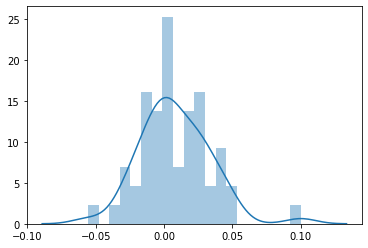

In [45]:
sns.distplot(next_weekly_retun_df.mean(axis=1), bins=20)

In [46]:
# 正解ラベルを作る
ground_truth_df = pd.merge(
    filter_friday(cv_all_df),
    next_weekly_retun_df.stack().rename({'EndOfDayQuote Close': 'NextWeeklyReturn'}, axis=1),
    left_index=True,
    right_index=True,
    how='left',
    sort=False
)[['NextWeeklyReturn']].fillna(0)

#feature_df = feature_df[:len(ground_truth_df)]
assert len(ground_truth_df) == len(filter_friday(cv_all_df))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and

In [47]:
return_df = create_weekly_return(cv_all_df)
prev_weekly_retun_df = return_df.reset_index().groupby('week_id').sum().shift().dropna()
prev_return_df = pd.merge(
    filter_friday(cv_all_df),
    prev_weekly_retun_df.stack().rename({'EndOfDayQuote Close': 'PrevReturn'}, axis=1),
    left_index=True,
    right_index=True,
    how='left',
    sort=False
)[['PrevReturn']].fillna(0)

#feature_df = feature_df[:len(ground_truth_df)]
assert len(prev_return_df) == len(filter_friday(cv_all_df))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/py

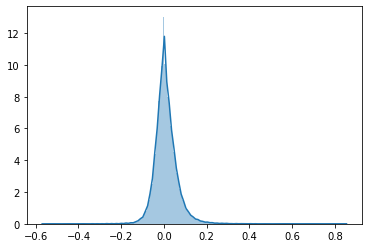

In [48]:
# 全銘柄、全期間の週次リターンの分布
sns.distplot(ground_truth_df, bins=200)

In [49]:
def drop_columns(input_df):
  drop_columns = [
                'volume_adi',
                'volume_obv',
                'volume_cmf',
                'volume_fi',
                'volume_mfi',
                'volume_em',
                'volume_sma_em',
                'volume_vpt',
                'EndOfDayQuote Volume',
                'EndOfDayQuote PreviousCloseDate',
                'EndOfDayQuote ChangeFromPreviousClose',
                'EndOfDayQuote PreviousExchangeOfficialCloseDate',
                'volume_nvi',
                'EndOfDayQuote Volume',
                'trend_stc',
                'EndOfDayQuote CumulativeAdjustmentFactor',
  ]
  return input_df.drop(drop_columns, axis=1)

In [50]:
def replace_column_name_space(input_df):
  out_df = input_df.copy()
  out_df.columns = input_df.columns.str.replace(' ', '')
  return out_df

In [51]:
def preprocess(input_df):
    return replace_column_name_space(
        drop_columns(
        add_prev_return_feature(
            input_df)))

In [52]:
def add_prev_return_feature(input_df):
    return_df = create_weekly_return(input_df)
    current_weekly_retun_df = return_df.reset_index().groupby('week_id').sum().dropna()
    prev_weekly_retun_df = return_df.reset_index().groupby('week_id').sum().shift().dropna()

    friday_df = filter_friday(input_df)
    df_ = pd.merge(
        friday_df,
        current_weekly_retun_df.stack().rename({'EndOfDayQuote Close': 'CurrentReturn'}, axis=1),
        left_index=True,
        right_index=True,
        how='left',
        sort=False
    )[['CurrentReturn']].fillna(0)

    return_df = pd.merge(
        df_,
        prev_weekly_retun_df.stack().rename({'EndOfDayQuote Close': 'PrevReturn'}, axis=1),
        left_index=True,
        right_index=True,
        how='left',
        sort=False
    )[['PrevReturn', 'CurrentReturn']].fillna(0)

    assert len(friday_df) == len(return_df), f'{len(friday_df)} != {len(return_df)}'
    return pd.concat([
                      friday_df,
                      return_df,
    ], axis=1)

In [53]:
processed_feature_df = preprocess(cv_all_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/py

In [54]:
processed_feature_df

EndOfDayQuoteOpen  EndOfDayQuotePreviousClose  EndOfDayQuoteVWAP  EndOfDayQuoteLow  \
week_id Local Code                                                                                       
14      1301                   2481.0                      2512.0           2486.863            2456.0   
        1332                    410.0                       414.0            415.177             408.0   
        1333                   2195.0                      2206.0           2177.651            2148.0   
        1377                   3085.0                      3080.0           3059.017            3000.0   
        1379                   1870.0                      1857.0           1844.097            1813.0   
...                               ...                         ...                ...               ...   
70      9984                   9918.0                      9891.0           9927.088            9861.0   
        9987                   3935.0                      3950.0           3937.314            3920.0   
        9991                    911.0                       910.0            904.906             893.0   
        9994                   2336.0                      2336.0           2325.642            2315.0   
        9997                   1165.0                      1168.0           1163.398            1157.0   

                    EndOfDayQuotePreviousExchangeOfficialClose  EndOfDayQuoteHigh  EndOfDayQuoteClose  \
week_id Local Code                                                                                      
14      1301                                            2512.0             2530.0              2496.0   
        1332                                             414.0              424.0               418.0   
        1333                                            2206.0             2223.0              2160.0   
        1377                                            3080.0             3150.0              3030.0   
        1379                                            1857.0             1898.0              1817.0   
...                                                        ...                ...                 ...   
70      9984                                            9891.0            10025.0              9885.0   
        9987                                            3950.0             3960.0              3935.0   
        9991                                             910.0              917.0               893.0   
        9994                                            2336.0             2337.0              2315.0   
        9997                                            1168.0             1173.0              1159.0   

                    EndOfDayQuoteExchangeOfficialClose  EndOfDayQuotePercentChangeFromPreviousClose   volume_vwap  \
week_id Local Code                                                                                                  
14      1301                                    2496.0                                       -0.637           NaN   
        1332                                     418.0                                        0.966           NaN   
        1333                                    2160.0                                       -2.085           NaN   
        1377                                    3030.0                                       -1.623           NaN   
        1379                                    1817.0                                       -2.154           NaN   
...                                                ...                                          ...           ...   
70      9984                                    9885.0                                       -0.061  10004.366286   
        9987                                    3935.0                                       -0.380   4042.897625   
        9991                                     893.0                                       -1.868    94

特徴量どうしの相関をプロットします。

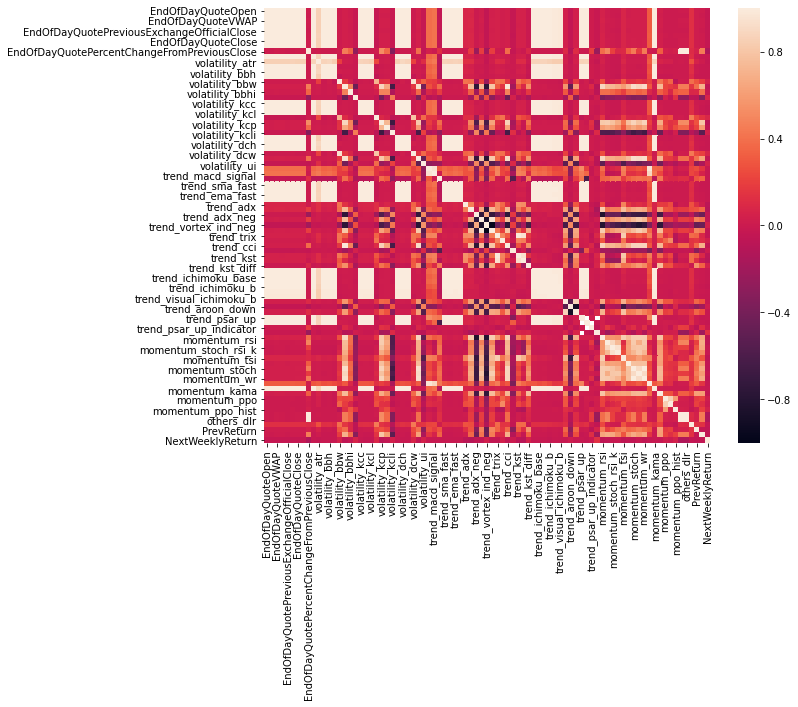

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
joined_df = pd.concat([
                       processed_feature_df,
                       ground_truth_df,
], axis=1)
sns.heatmap(joined_df.corr(), ax=ax, vmin=-1, vmax=1)

# 学習

モデルの設計は以下のようにしました。

* 任意の銘柄のテクニカル指標を予測する単一のモデルを作る(LightGBM)
* それぞれの fold で独立したモデルを作り、各foldで学習したモデルの予測値の平均値を最終的な予測値とする（合計10個分）

なお、ソースコードは [Atma Cup #10] のチュートリアルで使われていたものを改変して利用しています。

[Atma Cup #10]: https://www.guruguru.science/competitions/16

In [56]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time


class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [57]:
from abc import abstractmethod
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


class Base_Model(object):
    @abstractmethod
    def fit(self, x_train, y_train, x_valid, y_valid):
        raise NotImplementedError

    @abstractmethod
    def predict(self, model, features):
        raise NotImplementedError

    def cv(self, y_train, train_features, test_features, fold_ids):
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))

        # 各foldについて繰り返し
        for i_fold, (trn_idx, val_idx) in enumerate(fold_ids):
            x_trn = train_features.iloc[trn_idx]
            y_trn = y_train[trn_idx]
            x_val = train_features.iloc[val_idx]
            y_val = y_train[val_idx]

            # train/validデータを使ってモデルを学習する
            with Timer(prefix=f'fit fold={i_fold}'):
                model = self.fit(x_trn, y_trn, x_val, y_val)

            # valid/test データを予測する
            oof_preds[val_idx] = self.predict(model, x_val)
            oof_score = np.sqrt(mean_squared_error(y_val, oof_preds[val_idx]))
            print(f'Fold {i_fold} RMSLE: {oof_score:.4f}')
            test_preds += self.predict(model, test_features) / len(fold_ids)

        oof_score = np.sqrt(mean_squared_error(y_train, oof_preds))
        print('-' * 50)
        print(f'FINISHED | Whole RMSLE: {oof_score:.4f}')

        evals_results = {"evals_result": {
            "oof_score": oof_score,
            "n_data": len(train_features),
            "n_features": len(train_features.columns),
        }}

        return oof_preds, test_preds, evals_results


cat_col = []
class Lgbm(Base_Model):
    def __init__(self, model_params):
        self.model_params = model_params
        self.models = []
        self.feature_cols = None

    def fit(self, x_train, y_train, x_valid, y_valid):
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_valid = lgb.Dataset(x_valid, y_valid)

        model = lgb.train(self.model_params,
            train_set=lgb_train,
            valid_sets=[lgb_valid],
            valid_names=['valid'],
            early_stopping_rounds=50,
            num_boost_round=10000,
            verbose_eval=100)
        self.models.append(model)
        return model

    def predict(self, model, features):
        self.feature_cols = features.columns
        return model.predict(features)

    def visualize_importance(self, top_n=50):
        feature_importance_df = pd.DataFrame()

        for i,model in enumerate(self.models):
            _df = pd.DataFrame()
            _df['feature_importance'] = model.feature_importance(importance_type='gain')
            _df['column'] = self.feature_cols
            _df['fold'] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

        order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index[:top_n]

        fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
        sns.boxenplot(data=feature_importance_df,
                      x='feature_importance',
                      y='column',
                      order=order,
                      ax=ax,
                      palette='viridis',
                      orient='h')
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='x', rotation=90)
        ax.grid()
        fig.tight_layout()
        return fig, ax, order

今回の交差検証の切り方は独特なため、scikit learn のFoldクラスは利用せず、独自の交差検証処理を記述しました。

予め計算しておいた各foldの特徴量を使ってパラメータの学習と評価データの予測をしています。

In [58]:
def train_cv(model, y, train_folds, test_df):
  n_folds = len(train_folds) - 1

  last_fold = preprocess(train_folds[-1])
  first_fold = preprocess(train_folds[0])

  oof_preds = np.zeros(len(first_fold) - len(last_fold))
  test_preds = np.zeros(len(test_df))

  y_oof = y[len(last_fold):]

  models = []

  # fold 分繰り返す
  for fold_id in range(n_folds):
    # train / valid に データを分ける
    train_df, valid_df = create_cv_data_split(train_folds, fold_id)
    x_train = preprocess(train_df)
    x_valid = preprocess(valid_df)

    y_train = y[:len(x_train)]
    y_valid = y[len(x_train):len(x_train) + len(x_valid)]
    # trainデータを使ってモデルを学習する
    with Timer(prefix=f'fit fold={fold_id}'):
      learned_model = model.fit(x_train, y_train, x_valid, y_valid)

    # valid, test データを予測する
    offset = len(last_fold)
    oof_pred = model.predict(learned_model, x_valid)

    oof_preds[len(x_train) - offset:len(x_train) + len(x_valid) - offset] = oof_pred
    oof_score = np.sqrt(mean_squared_error(y_valid, oof_pred))
    print(f'Fold {fold_id} RMSLE: {oof_score:.4f}')
    test_preds += model.predict(learned_model, test_df) / n_folds

    models.append(learned_model)

  oof_score = np.sqrt(mean_squared_error(y_oof, oof_preds))
  print('-' * 50)
  print(f'FINISHED | Whole RMSLE: {oof_score:.4f}')

  return models, oof_preds, test_preds

In [61]:
def fit_lgbm(y, train_folds, test_df):
  lgbm_params = {
      'boosting_type': 'gbdt',
      'objective': 'regression',
      'metric': 'rmse',
      'num_leaves': 20,
      'learning_rate': 0.01,
      'verbose': 100,
  }

  model = Lgbm(lgbm_params)
  models, oof_pred, test_pred = train_cv(model, y, train_folds, test_df)

  return model, models, oof_pred, test_pred

In [62]:
import warnings

warnings.simplefilter('ignore')

test_df = preprocess(cv_test_df)
train_df = preprocess(cv_train_df)
valid_df = preprocess(cv_valid_df)
y = ground_truth_df['NextWeeklyReturn'][:len(train_df) + len(valid_df)].values

model, models, oof_pred, test_pred = fit_lgbm(y, train_folds, test_df)

warnings.resetwarnings()

Training until validation scores don't improve for 50 rounds.
[100]	valid's rmse: 0.041741
[200]	valid's rmse: 0.0414579
[300]	valid's rmse: 0.0414723
Early stopping, best iteration is:
[264]	valid's rmse: 0.0414433
fit fold=0 12.680[s]
Fold 0 RMSLE: 0.0414
Training until validation scores don't improve for 50 rounds.
[100]	valid's rmse: 0.0444813
Early stopping, best iteration is:
[134]	valid's rmse: 0.0444625
fit fold=1 7.695[s]
Fold 1 RMSLE: 0.0445
Training until validation scores don't improve for 50 rounds.
[100]	valid's rmse: 0.0412867
[200]	valid's rmse: 0.0412909
Early stopping, best iteration is:
[164]	valid's rmse: 0.0412312
fit fold=2 8.735[s]
Fold 2 RMSLE: 0.0412
Training until validation scores don't improve for 50 rounds.
[100]	valid's rmse: 0.0464082
Early stopping, best iteration is:
[133]	valid's rmse: 0.0463132
fit fold=3 7.523[s]
Fold 3 RMSLE: 0.0463
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid's rmse: 0.0

# 評価

In [63]:
last_fold = preprocess(train_folds[-1])
y_oof = y[len(last_fold):]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/py

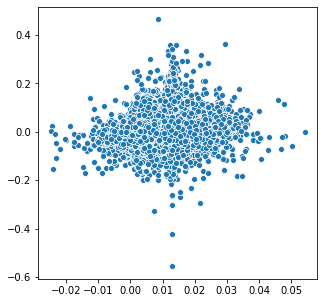

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(oof_pred, y_oof, ax=ax)

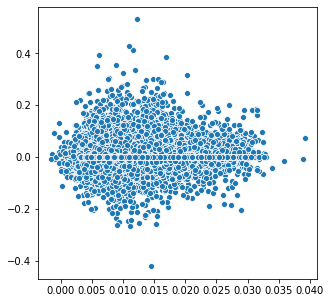

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
y_test = ground_truth_df['NextWeeklyReturn'][len(ground_truth_df) - len(test_df):].values
sns.scatterplot(test_pred, y_test, ax=ax)

モデルのあてはまりの良さを評価するために、公式のチュートリアルと同じく順序相関を確認します。
後述するように、今回はモデルの予測値が大きい順に銘柄を選択しているため、順序の相関を見ることは理にかなっています。

In [67]:
from scipy import stats

def calc_correlation(y, y_pred):
  spearman_r, _ = stats.spearmanr(y, y_pred)
  kendall_tau, _ = stats.kendalltau(y, y_pred)

  print(f'Spearman\'s ro: {spearman_r:5.5f}')
  print(f'Kendall\'s tau: {kendall_tau:5.5f}')

In [68]:
calc_correlation(y_test, test_pred)

Spearman's ro: 0.10188
Kendall's tau: 0.06838


正解と予測値の分布は以下のとおり。
モデルの予測値は大半が正の値をとっていて、強気な予測をするモデルであることがわかります。
コロナ禍で株価が全般的に下落した2020年3月のデータを学習期間に含めていないため、このような結果となったのかもしれません。

なお、経験的に、LightGBMで回帰を行う場合、正解データの分布よりも予測データの分布のほうがばらつきが小さくなる傾向があります。
（想像ですが、ノイズ分が相殺されて期待値にフィットしようとするためと考えています）。

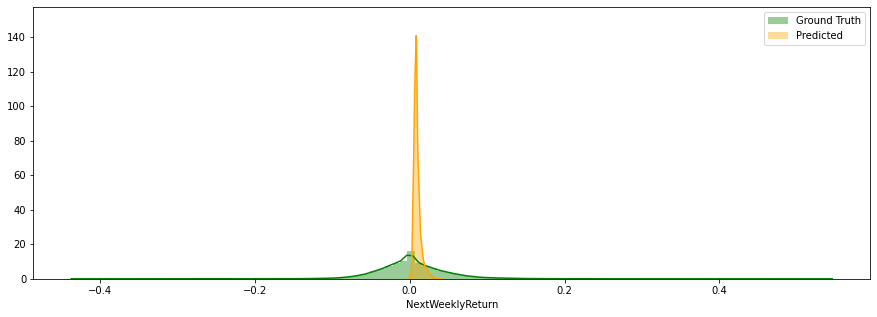

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.distplot(ground_truth_df['NextWeeklyReturn'][len(ground_truth_df) - len(test_df):], bins=100, ax=ax, color='green', label='Ground Truth')
sns.distplot(test_pred, bins=100, ax=ax, color='orange', label='Predicted')
ax.legend()

特徴量重要度を確認します。foldごとにかなりばらついているように見えますが、これはいくつかのFoldでモデルの学習に失敗して予測値が定数になっているためです。

この原因は特定できていませんが、定常的なノイズが加わっても銘柄選択には影響しないため、無視しています。

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

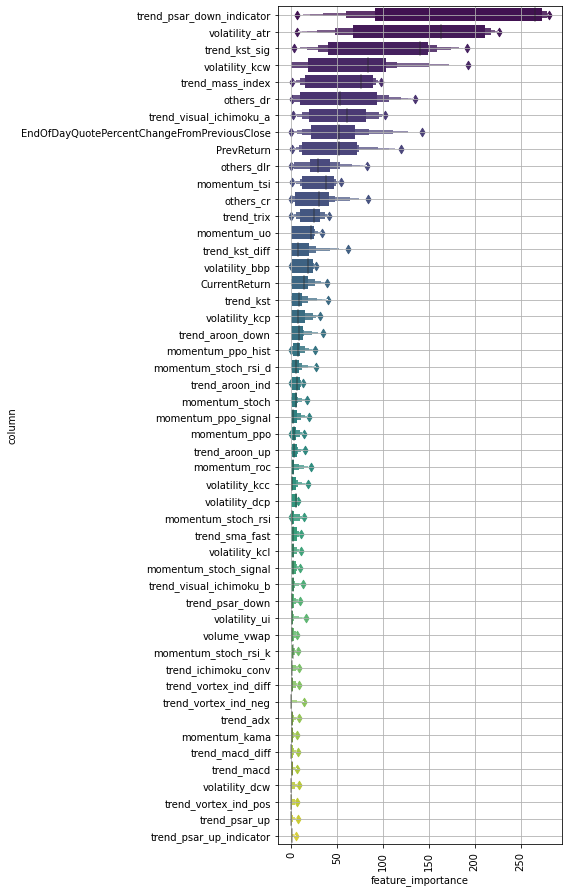

In [70]:
import warnings

warnings.simplefilter('ignore')

model.visualize_importance()

warnings.resetwarnings()

# ポートフォリオ作成

ポートフォリオは以下のように設計しました。

* モデルの予測値が大きい順に、上位5銘柄を選択する
* 予測値に応じて購入金額を分配する

銘柄$i$の購入額$P_i$の計算式は以下です:
$$P_i = \mathrm{budget} - (\mathrm{offset} * n)) * \frac{\mathrm{max}(\hat{y}_i, 0)}{\sum_{i}{\mathrm{max}(\hat{y}_i, 0)} + \delta} + \mathrm{offset}$$

* $\hat{y_i}$: 銘柄$i$の予測リターン
* $\mathrm{budget}$: ラウンドの予算(今回は百万円)
* $\delta$: zero division を回避するための定数(=0.0001とした)
* $\mathrm{offset}$: 最低購入額(=100円とした)
* $n$: ポートフォリオに組み入れる銘柄の数(=5とした)

銘柄の予測値を重みとして合計額が100万円となるように比例分配しています。
また、細かい調整として、モデルの予測値が負だった場合でも正しく計算できるように、銘柄の最低購入額を100円としています（あとで気づきましたが、これだと1銘柄の価格が100円未満の場合に銘柄が購入できないため、失格となる可能性があります。実際は最低購入額を1万円くらいに設定するのが妥当だったと思います）。

In [71]:
y_test = ground_truth_df[len(ground_truth_df) - len(test_df):]
z = np.maximum(test_pred, 0)

pred_df = pd.concat([
                     y_test,                
                     pd.DataFrame({'PredictedWeeklyReturn': test_pred}, index=y_test.index),
                     pd.DataFrame({'Confidence': z}, index=y_test.index),
], axis=1)

In [72]:
pred_df

NextWeeklyReturn  PredictedWeeklyReturn  Confidence
week_id Local Code                                                     
52      1301                0.012011               0.005496    0.005496
        1332                0.007283               0.006259    0.006259
        1333                0.014210               0.008099    0.008099
        1377               -0.005464               0.008484    0.008484
        1379               -0.011813               0.007172    0.007172
...                              ...                    ...         ...
70      9984                0.000000               0.010557    0.010557
        9987                0.000000               0.010995    0.010995
        9991                0.000000               0.023773    0.023773
        9994                0.000000               0.008486    0.008486
        9997                0.000000               0.011898    0.011898

[30254 rows x 3 columns]

In [73]:
def print_performance(week):
  filter_week = pred_df.index.get_level_values(0) == week
  ranking_df = pred_df[filter_week].sort_values('PredictedWeeklyReturn', ascending=False).reset_index()[['Local Code', 'PredictedWeeklyReturn', 'NextWeeklyReturn']]
  oracle_df = pred_df[filter_week].sort_values('NextWeeklyReturn', ascending=False).reset_index()[['Local Code', 'PredictedWeeklyReturn', 'NextWeeklyReturn']]

  for rank in range(5, 30, 5):
    print(f'Performance of Predicted Top({rank}): {ranking_df.head(rank)["NextWeeklyReturn"].mean():5.5f}')
    print(f'Performance of Oracle Top({rank}): {oracle_df.head(rank)["NextWeeklyReturn"].mean():5.5f}')  

In [74]:
def calculate_performance(input_df, top_n=30, inc=5):
  '''
  TopN 銘柄の当分配ポートフォリオのリターンを計算する
  '''
  weeks = input_df.index.get_level_values(0).unique().values
  columns = []
  for rank in range(inc, top_n + inc, inc):
    columns.append(f'PredictTop{rank}')
  columns.append('Universe')

  hash = {}
  for column in columns:
    hash[column] = []

  for week in weeks:
    filter_week = input_df.index.get_level_values(0) == week
    ranking_df = input_df[filter_week].sort_values('PredictedWeeklyReturn', ascending=False).reset_index()

    i = 0
    for rank in range(inc, top_n + inc, inc):
      ranking_df.head(rank)
      hash[columns[i]].append(ranking_df.head(rank)['NextWeeklyReturn'].mean())
      i += 1
    hash['Universe'].append(ranking_df['NextWeeklyReturn'].mean())

  out_df = pd.DataFrame(hash)

  return out_df

In [75]:
def calculate_weighted_performance(input_df, top_n=30, inc=5):
  '''
  TopN 銘柄の自信度に比例したポートフォリオのリターンを計算する
  '''
  weeks = input_df.index.get_level_values(0).unique().values
  columns = []
  for rank in range(inc, top_n + inc, inc):
    columns.append(f'PredictTop{rank}')
  columns.append('Universe')

  hash = {}
  for column in columns:
    hash[column] = []

  for week in weeks:
    filter_week = input_df.index.get_level_values(0) == week
    ranking_df = input_df[filter_week].sort_values('PredictedWeeklyReturn', ascending=False).reset_index()

    i = 0
    for rank in range(inc, top_n + inc, inc):
      ranking_df.head(rank)
      portfolio_single_return_df = ranking_df.head(rank)['NextWeeklyReturn']
      portfolio_confidence_df = ranking_df.head(rank)['Confidence']
      portfolio_return_df = portfolio_single_return_df * portfolio_confidence_df.div(portfolio_confidence_df.sum())

      hash[columns[i]].append(portfolio_return_df.sum())
      i += 1
    hash['Universe'].append(ranking_df['NextWeeklyReturn'].mean())

  out_df = pd.DataFrame(hash)

  return out_df

In [76]:
performance_df = calculate_performance(pred_df)
weighted_performance_df = calculate_weighted_performance(pred_df)

In [77]:
performance_df.cumsum()

,PredictTop5,PredictTop10,PredictTop15,PredictTop20,PredictTop25,PredictTop30,Universe
0,0.058582,0.046409,0.027273,0.022880,0.014798,0.014345,0.006605
1,0.060587,0.054189,0.036532,0.016036,0.008180,0.004604,0.001302
2,0.088529,0.054028,0.026822,0.004695,0.000593,0.002836,0.004399
3,0.099513,0.050726,0.030509,0.005265,0.007732,0.005112,-0.007140
4,0.217124,0.140212,0.111705,0.076586,0.080827,0.077059,0.036449
5,0.245354,0.152821,0.123623,0.111737,0.111529,0.098525,0.051654
6,0.246639,0.133900,0.099575,0.087552,0.083313,0.065264,0.035324
7,0.300862,0.132190,0.087424,0.078314,0.067585,0.046230,0.013952
8,0.297336,0.139742,0.090088,0.084994,0.079825,0.060689,0.032678
9,0.308725,0.163106,0.117505,0.119392,0.119432,0.096964,0.066049


In [78]:
weighted_performance_df.cumsum()

,PredictTop5,PredictTop10,PredictTop15,PredictTop20,PredictTop25,PredictTop30,Universe
0,0.058521,0.046935,0.028847,0.024403,0.016761,0.016011,0.006605
1,0.063437,0.055624,0.038325,0.019810,0.011952,0.008348,0.001302
2,0.091272,0.055994,0.029648,0.009441,0.004816,0.006486,0.004399
3,0.101882,0.052926,0.033179,0.010109,0.011646,0.008890,-0.007140
4,0.213758,0.141452,0.114242,0.081985,0.085079,0.081216,0.036449
5,0.239926,0.154503,0.126510,0.114590,0.114308,0.102817,0.051654
6,0.242464,0.137472,0.104357,0.091918,0.088072,0.072240,0.035324
7,0.295477,0.137625,0.094024,0.083958,0.073878,0.054855,0.013952
8,0.291934,0.144903,0.096616,0.090436,0.085740,0.068923,0.032678
9,0.303973,0.168204,0.123651,0.123978,0.124096,0.104521,0.066049


## パフォーマンスの評価

テスト期間の18週（最終週は正解値が不明のため実質17週）のパフォーマンスをプロットします。

この結果からは、ポートフォリオに組み入れる銘柄が5銘柄の場合に、最も高いリターンの期待値が得られています。

また、SHARPレシオも5銘柄を選択した場合が最も高く、リスクとリターンのバランスも良さそうです。

したがって、最終的に提出したモデルではポートフォリオに上位5銘柄を組み入れました。

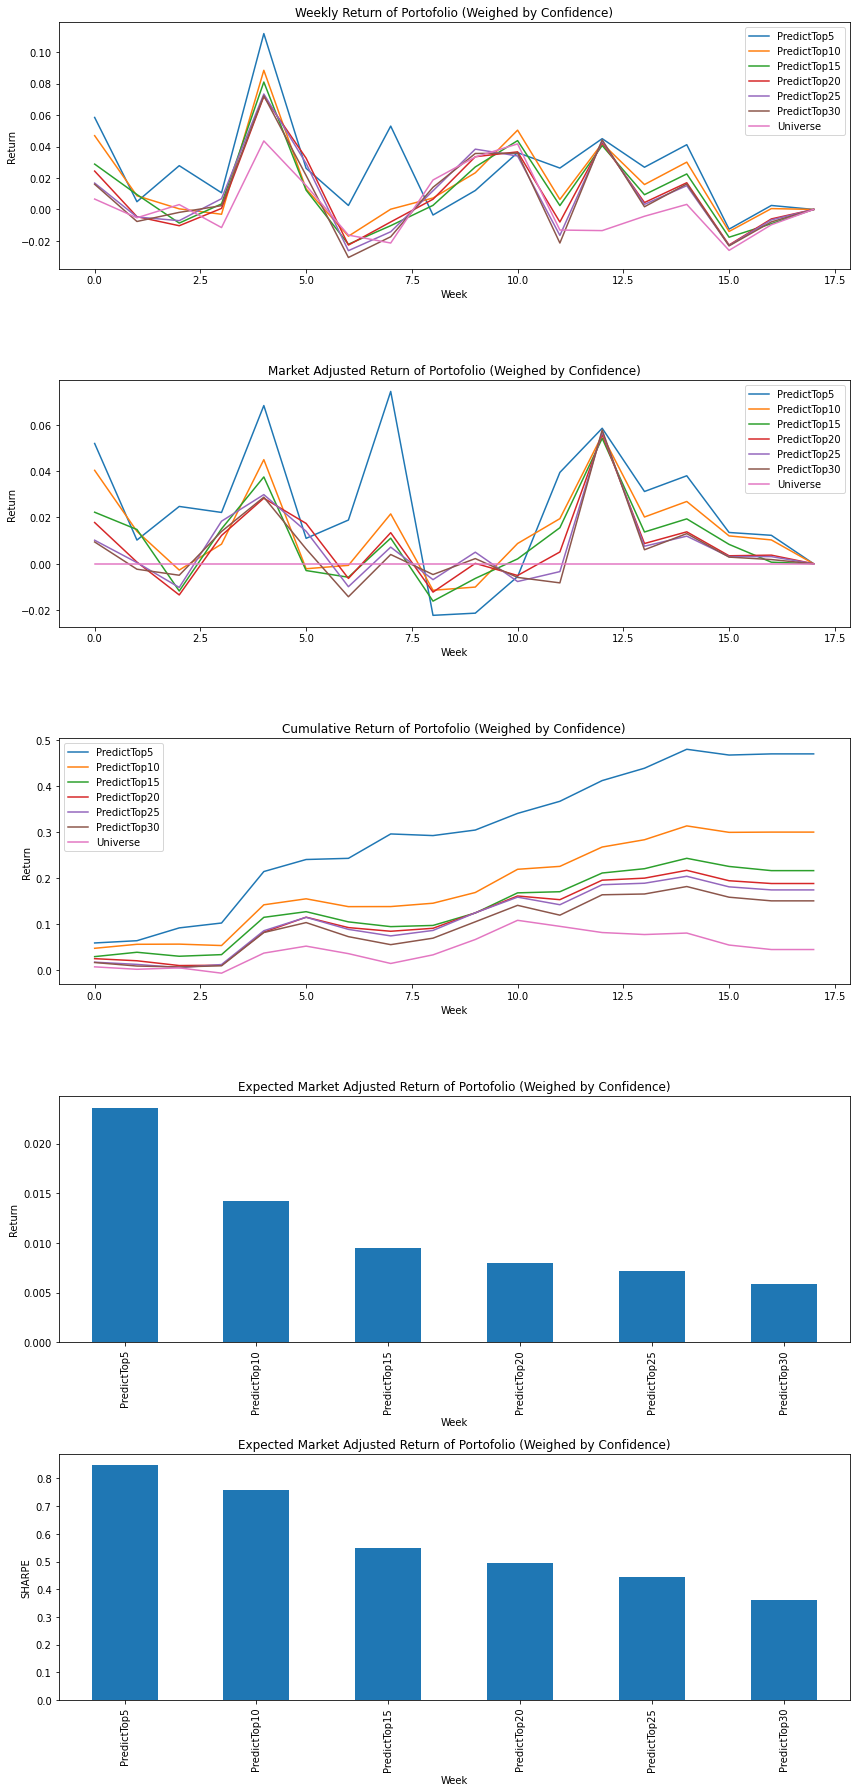

In [79]:
fig, ax = plt.subplots(5, 1, figsize=(12, 25))

i = 0

weighted_performance_df.plot(ax=ax[i])
ax[i].title.set_text('Weekly Return of Portofolio (Weighed by Confidence)')
ax[i].set_xlabel('Week')
ax[i].set_ylabel('Return')

i = 1

weighted_performance_df.sub(performance_df['Universe'], axis='index').plot(ax=ax[i])
ax[i].title.set_text('Market Adjusted Return of Portofolio (Weighed by Confidence)')
ax[i].set_xlabel('Week')
ax[i].set_ylabel('Return')

i = 2

weighted_performance_df.cumsum().plot(ax=ax[i])
ax[i].title.set_text('Cumulative Return of Portofolio (Weighed by Confidence)')
ax[i].set_xlabel('Week')
ax[i].set_ylabel('Return')

i = 3

weighted_performance_df.sub(performance_df['Universe'], axis='index').drop('Universe', axis=1).mean().plot.bar(ax=ax[i])
ax[i].title.set_text('Expected Market Adjusted Return of Portofolio (Weighed by Confidence)')
ax[i].set_xlabel('Week')
ax[i].set_ylabel('Return')

i = 4

w_market_adjusted_df = weighted_performance_df.sub(performance_df['Universe'], axis='index')
w_sigma_df = weighted_performance_df.sub(performance_df['Universe'], axis='index').std()

(w_market_adjusted_df / w_sigma_df).drop('Universe', axis=1).mean().plot.bar(ax=ax[i])
ax[i].title.set_text('Expected Market Adjusted Return of Portofolio (Weighed by Confidence)')
ax[i].set_xlabel('Week')
ax[i].set_ylabel('SHARPE')

plt.tight_layout()

# ハイパーパラメータチューニング

モデルのハイパーパラメータとしては、以下のパターンを検証しました。

* 学習に使った fold 数: 5, 10, 20
* 特徴量
  - テクニカル指標のみ
  - テクニカル指標 + 銘柄コード
  - テクニカル指標 + 当該週リターン + 前週リターン

これらのうち、特徴量に銘柄コードを利用した場合は、パフォーマンスが悪化したため、銘柄コードは特徴量から除外することにしました。
想像ですが、銘柄コードはカーディナリティが大きい(約1700個)ため、これを特徴量に入れることでフィットするパラメータが多くなり、結果として学習しずらくなったためではないかと考えています。

また、テクニカル指標に当該週と前週のリターンを追加した場合は、テクニカル指標のみの場合と比べて17週のリターンが大きくなりました。

最終提出モデルは17週のリターンが最も大きかった以下としました。

* 学習に使った fold 数: 10
* 特徴量
  - テクニカル指標 + 当該週リターン + 前週リターン


# やれなかったこと

以下は検証する価値がありましたが、時間の都合上、また、サブミット数の都合上できませんでした。

* 特徴量に以下を追加する
  - マーケットのリターン（当該週、前週）
  - マーケット調整済みリターン（当該週、前週）
* 時系列モデル(LSTM)を使って学習する

# 学習済みモデルデータの保存

以下は学習ずみのモデルデータをDriveに保存するソースコードです

In [80]:
import pickle

# モデル保存用にメソッドを定義します
def save_model(model, label, model_path):
    # モデル保存先ディレクトリを作成
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"model_{label}.pkl"), "wb") as f:
        # モデルをpickle形式で保存
        pickle.dump(model, f)

In [ ]:
PROJECT_DIR = os.path.join(mount_dir, 'MyDrive', 'Colab Notebooks', 'JPX_Competition', '005-1-1c')
assert os.path.isdir(PROJECT_DIR)

In [ ]:
for i, model in enumerate(models):
  save_model(model, f'lgbm_{i:03d}', os.path.join(PROJECT_DIR, 'archive', 'model'))